# Problem Statment

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly. 

In [2]:
import math
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from keras.layers import Dense
# import tensorflow as tf
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import Binarizer, LabelEncoder, StandardScaler
from statsmodels.tools import add_constant as ac

sc = StandardScaler()
le = LabelEncoder()

from sklearn.ensemble import (BaggingRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (KFold, RandomizedSearchCV,
                                     StratifiedKFold, train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

rfr = RandomForestRegressor()
import warnings

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.svm import SVR
from statsmodels.formula.api import ols

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
for i in train.columns:
    if i not in test.columns:
        target_var = i 
        print(target_var)

Item_Outlet_Sales


In [5]:
# Correcting data in Item Fat Content
def correct_fat_content(df):
    df.Item_Fat_Content.replace(to_replace=['LF','low fat'], value = 'Low Fat', inplace=True)
    df.Item_Fat_Content.replace(to_replace=['reg'], value = 'Regular', inplace=True)
    print(df.Item_Fat_Content.value_counts())

In [6]:
# This function would return the last created submission file with the name 
# provided(x), so that the next submission file would be named with the next 
# number automatically. 
# Like Sub1, Sub2.  

def ret_latest_file(x):
    ans = os.listdir()
    finlist = []
    re_pat = re.compile("([a-zA-Z]+)([0-9]+)")
    for i in ans:
        try:            
            if i[-3:] == 'csv':
                res = re_pat.match(i).groups()    #type: ignore
                if res[0] == x:
                    finlist.append(int(res[1]))            
        except:
            pass
    if len(finlist) > 0:
        return x, max(finlist)
    else:
        return x, 0

In [7]:
# Preparing Data for submission

def sub(n, pred):
    name, num = ret_latest_file(n)
    sol = pd.read_csv('./Data/sample_submission_1.csv')
    sol.loc[:, target_var] = pred #type: ignore
    sol.to_csv(f'./Submissions/{name}_{num+1}.csv', index=False)

In [8]:
# Splitting combined into x_train, x_test, y_train, y_test

def split_data(df, y = target_var):

    x_train = df[df[y].notnull()]
    x_train.drop(y, inplace=True, axis=1)

    x_test = df[df[y].isnull()]
    x_test.drop(y, inplace=True, axis=1)
    y_train = df[df[y].notnull()][y]

    y_test = df[df[y].isna()][y]

    return x_train, x_test, y_train, y_test

In [9]:
# Feature Importance

def feat_imp(df, model):
    x_train, x_test, y_train, y_test = split_data(df)
    features = model.feature_importances_
    sorted_indices = np.argsort(features)[::-1]
    plt.title('Feature Importance')
    plt.bar(range(x_train.shape[1]), features[sorted_indices], align='center')
    plt.xticks(range(x_train.shape[1]), x_train.columns[sorted_indices], rotation=90)
    plt.tight_layout()
    plt.show()

    return list(x_train.columns[sorted_indices])

In [10]:
combined = pd.concat([train, test], sort = False, ignore_index = True)

## ***EDA Process***
### **1. Univariate Analysis - Single Variable Analysis.**


Two types of column : Numeric and Categorical

For Numeric : Histogram

For Categorical : Frequency Table / Countplot.



In [11]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB


In [12]:
not_plot = ['Item_Identifier']
color = ['blue', 'red','green']

In [13]:
def univariate(df = combined, rows = 4, cols = 3):
    k = 0
    fig=plt.figure(figsize=(20,20))
    for i in df.columns:
        if i not in not_plot:
            if i in df.select_dtypes(['category', 'object']).columns:
                ax=fig.add_subplot(rows,cols,k+1)
                sns.countplot(x= i, data = df, ax=ax)
                plt.xticks(rotation = 45)
                k += 1
            if i in df.select_dtypes(['int', 'float']).columns:
                ax=fig.add_subplot(rows,cols,k+1)
                sns.distplot(x = df[i], ax=ax, color=np.random.choice(color))
                ax.set(xlabel=i)
                k += 1
    fig.tight_layout() 
    plt.show()

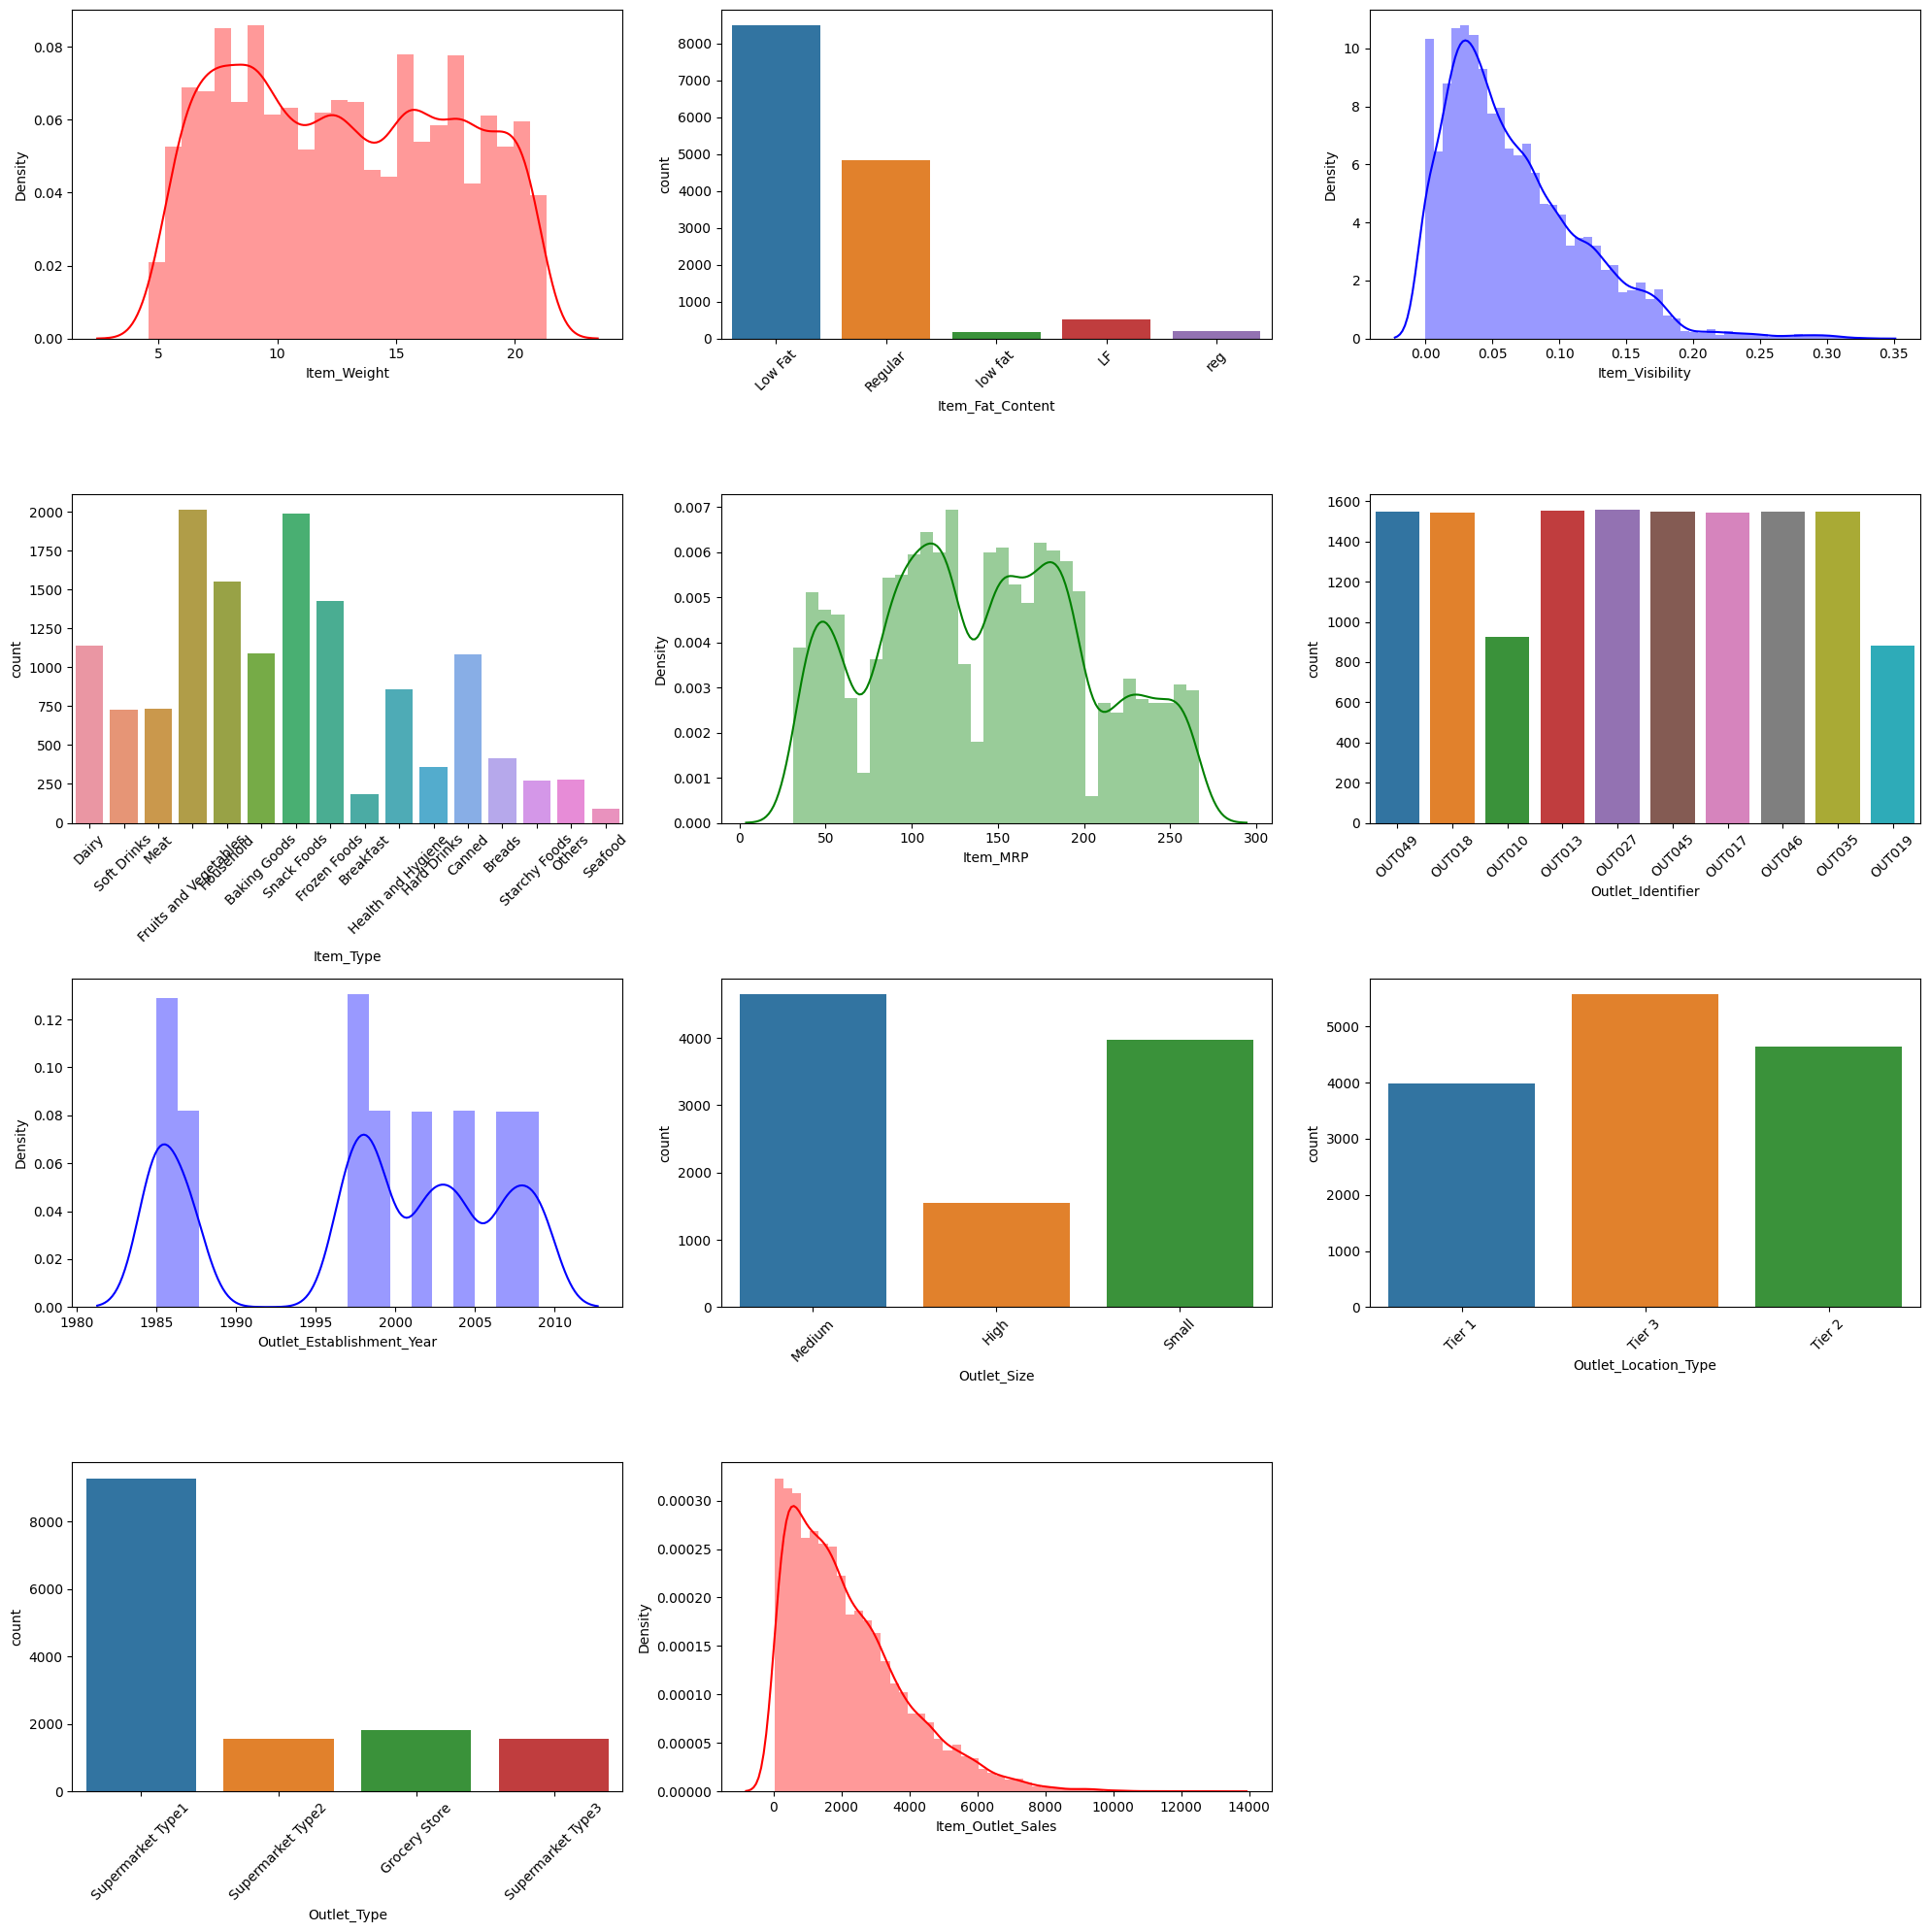

In [14]:
univariate()

In [15]:
# Correcting Item_Fat_Content Column
correct_fat_content(combined)

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


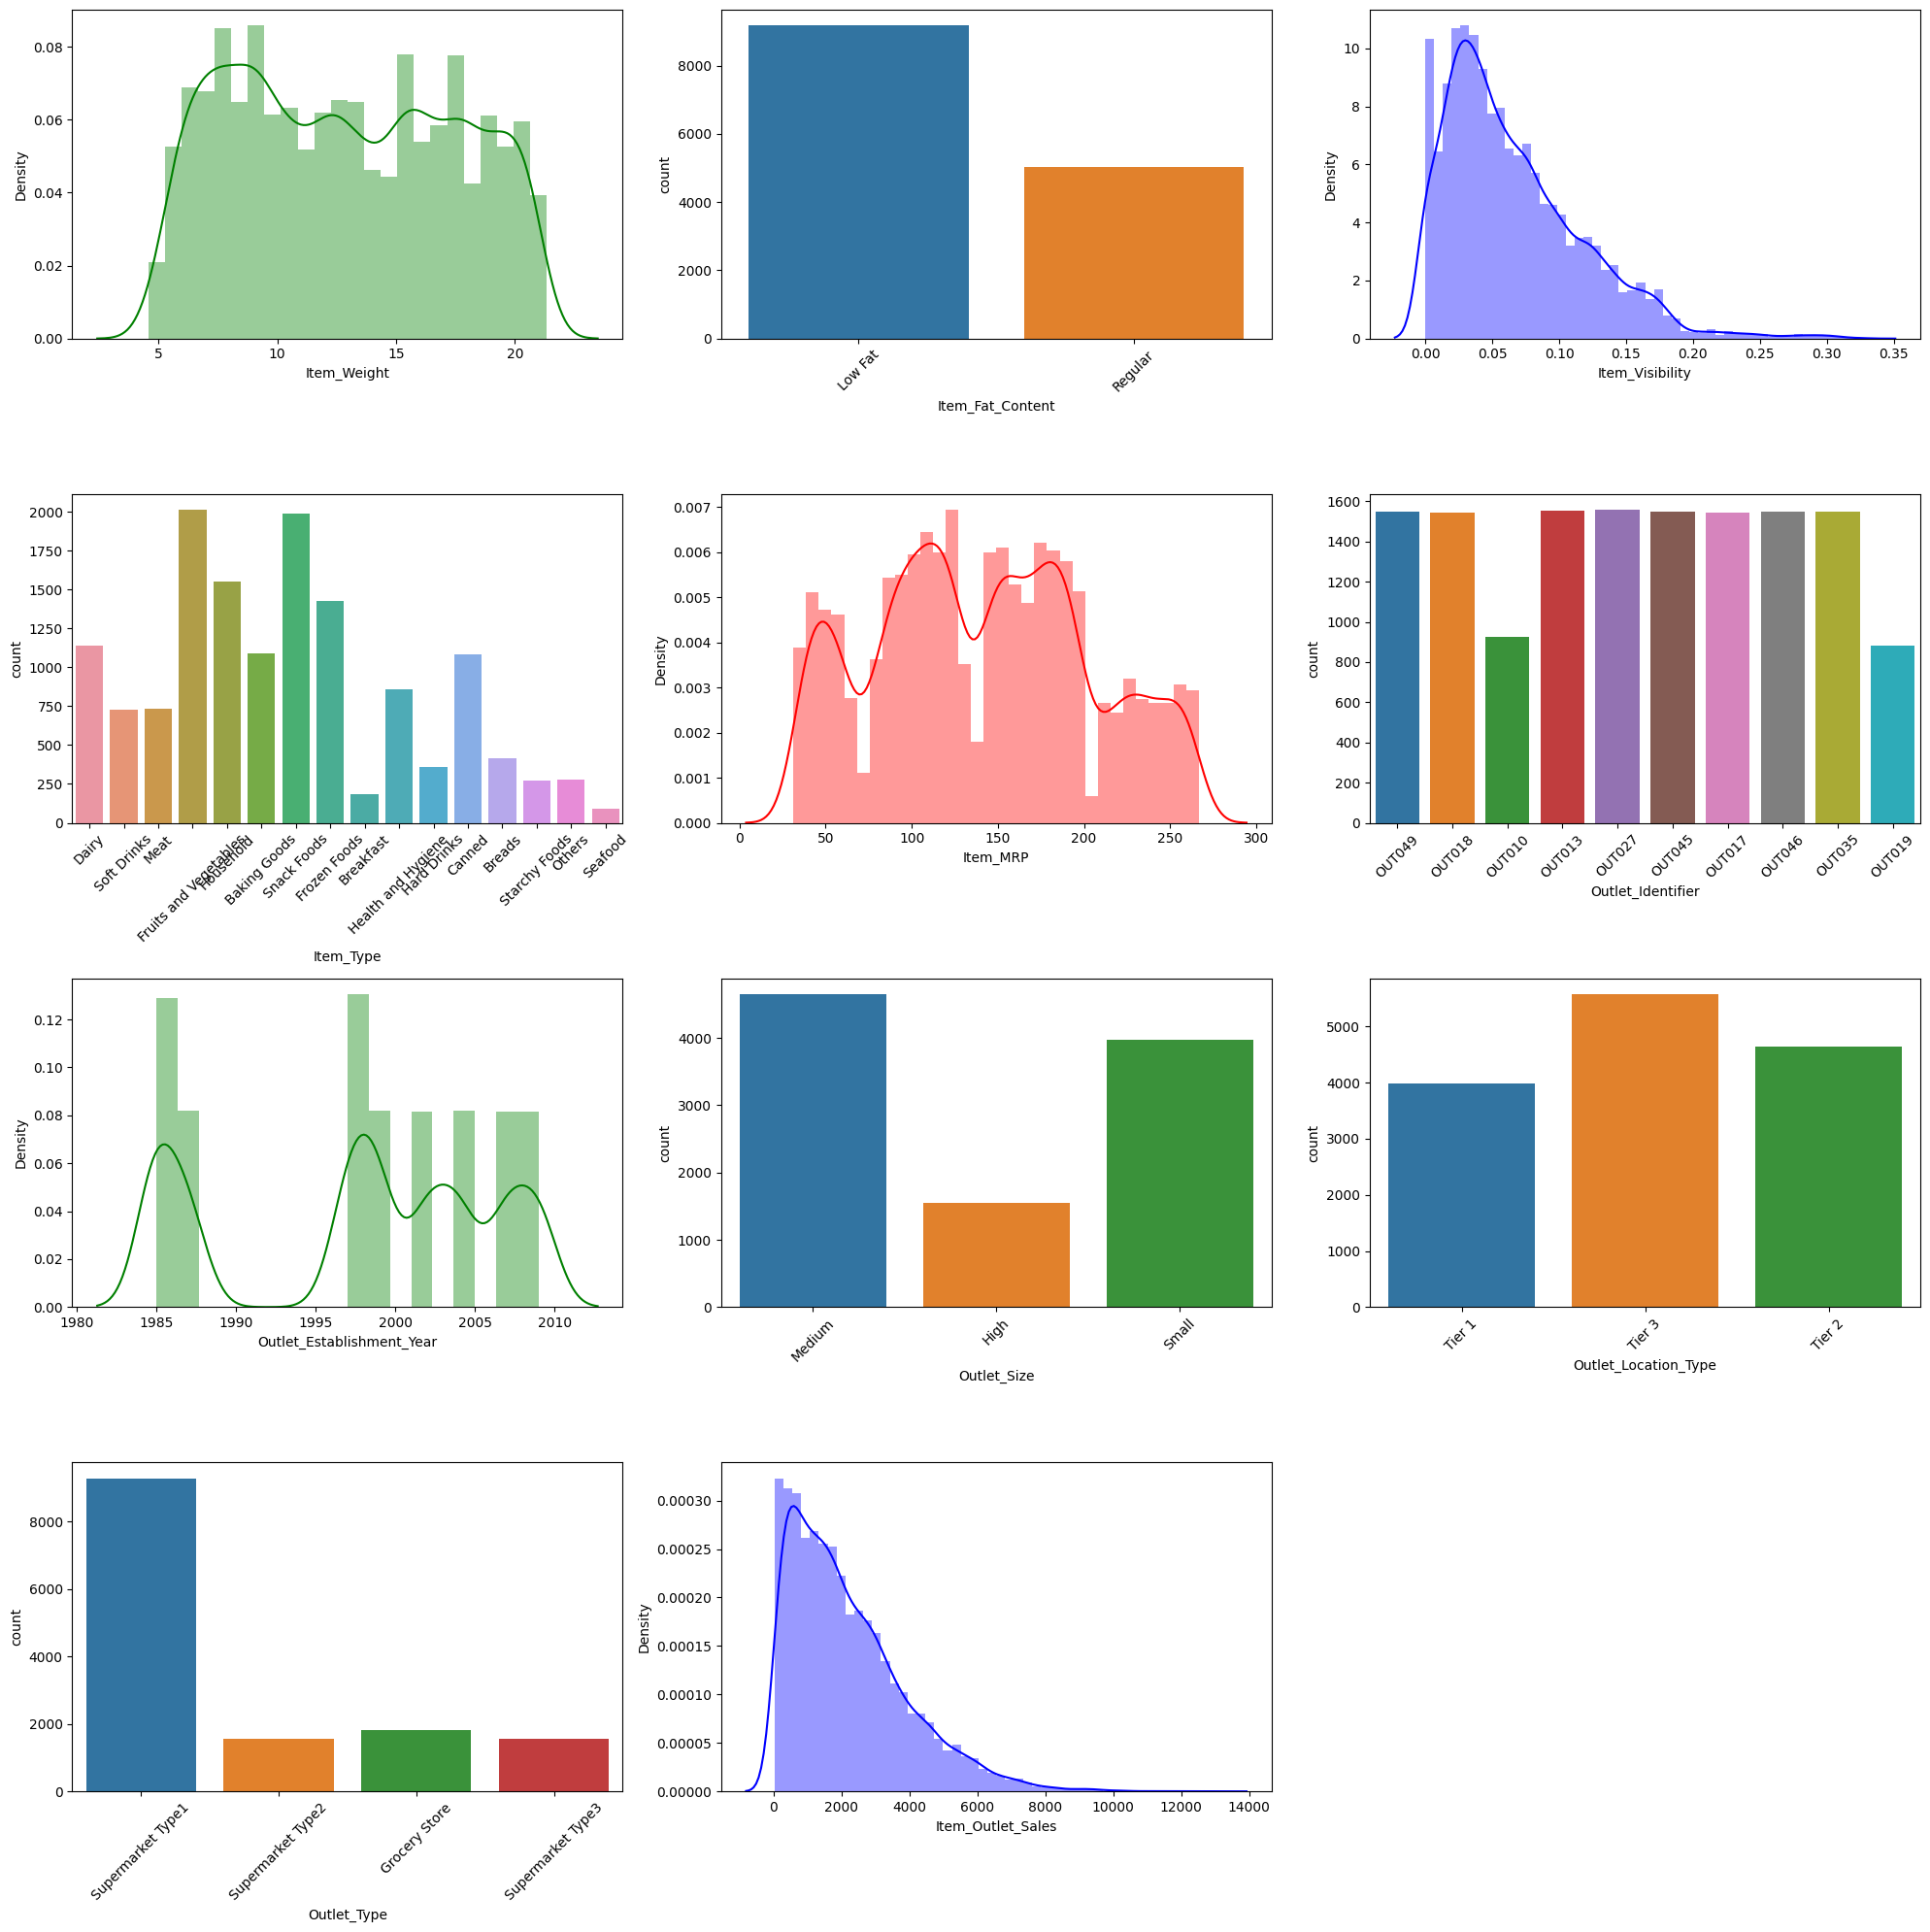

In [16]:
univariate()

### **2. Bivariate Analysis - Two Variable Analysis.**


Numeric vs Numeric - Scatter Plot.

Numeric vs Categorical - Box Plot or Bar Plot.



In [17]:
def bivariate(df = combined, y = target_var, cols = 4, rows = 8):
    temp = not_plot[:]
    temp.append(str(y))
    k = 0
    fig=plt.figure(figsize=(25,20))

    for i in df.columns:
        if i not in temp:
            if y in df.select_dtypes(['float', 'int']):
                if i in df.select_dtypes(['category', 'object']):
                    if (i not in temp): 
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.boxplot(x = i, y = y, data = df)

                if i in df.select_dtypes(['float', 'int']):                
                    if (i not in temp):      
                        ax=fig.add_subplot(rows,cols,k+1)       
                        sns.scatterplot(x = y, y = i, data = df)                  
                k += 1
            elif y in df.select_dtypes(['category', 'object']):
                if i in df.select_dtypes(['category', 'object']):
                    if (i not in temp):
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.countplot(x = i, hue = y, data = df)
                        plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

                if i in df.select_dtypes(['float', 'int']):
                    if (i not in temp):
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.boxplot(x = y, y = i, data = df)
                k += 1
    fig.tight_layout() 
    plt.show()

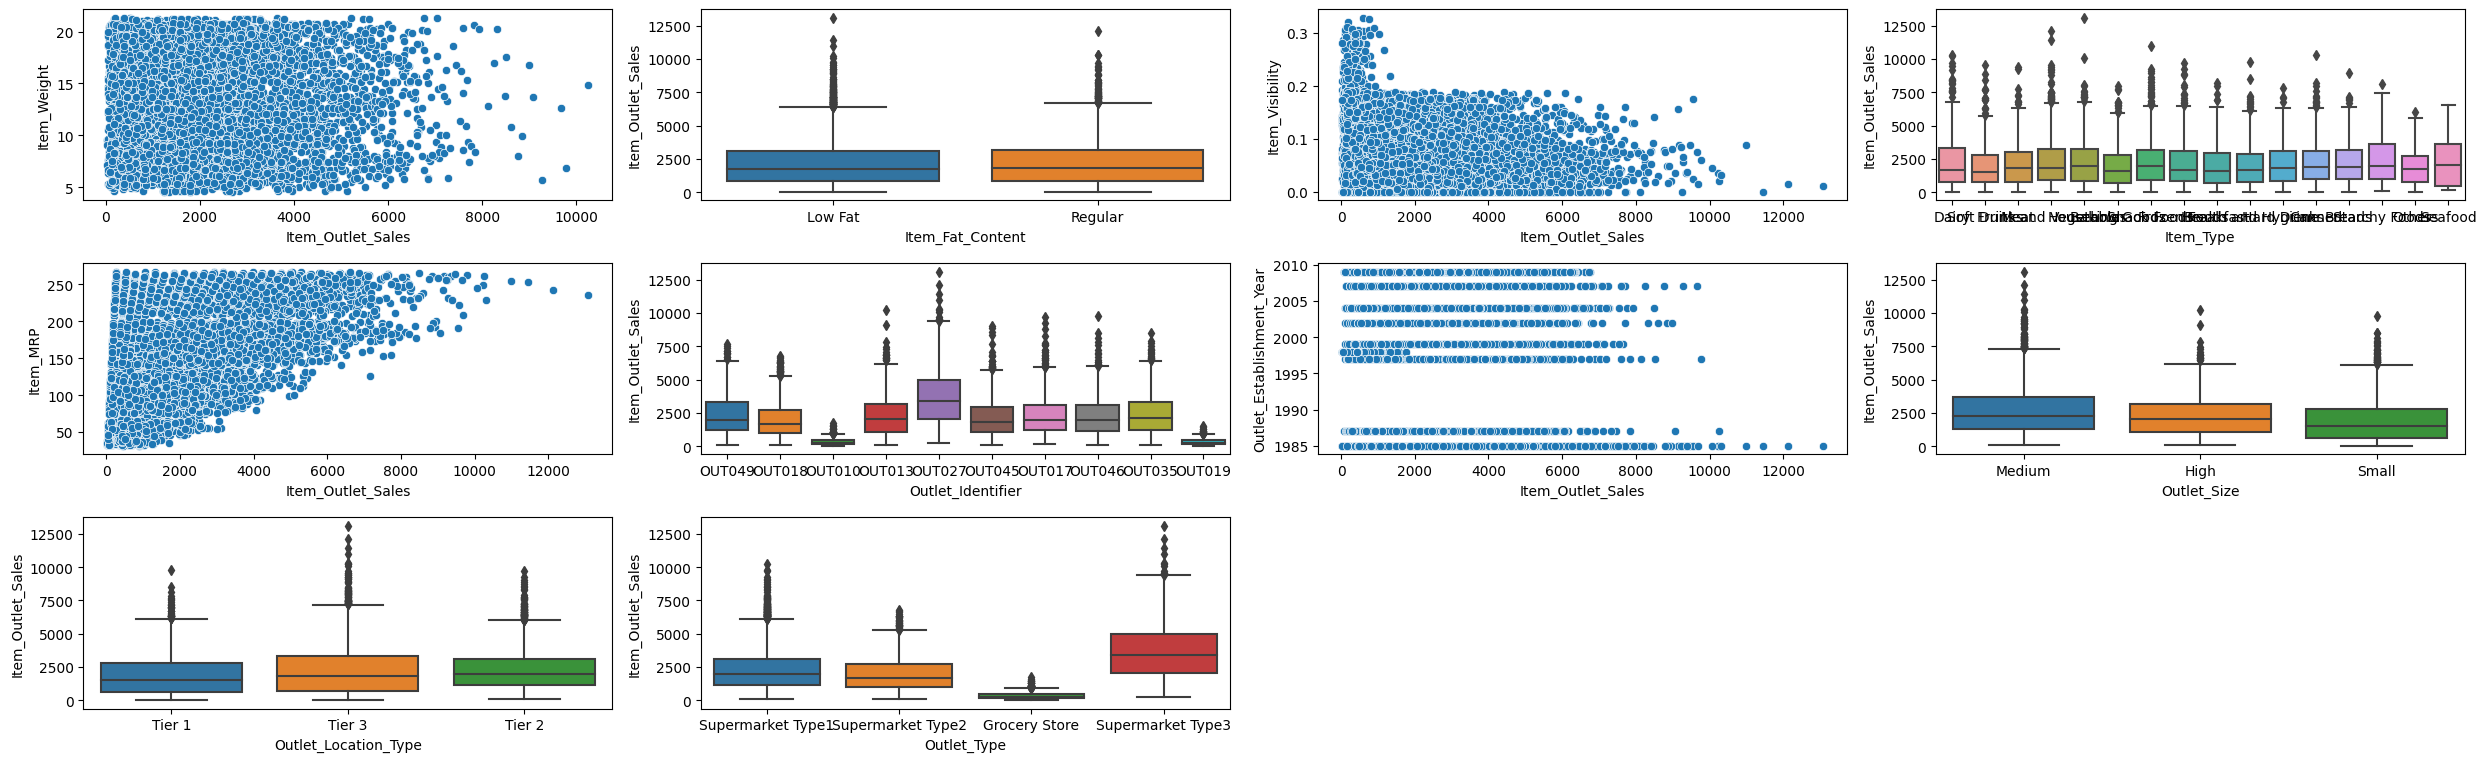

In [18]:
# Outlet_Sales is the Dependent Variable

bivariate()

### **3. Missing Values.**

1. Drop NA : Not Correct approach (ignore lot of info).


> Note: Only good when more than 90 % values are missing.

2. Dealing with Missing Values - If column is numeric, then there are several approaches out of which we will discuss two.

> * Find the Descriptive statistics of
that column. If the values are skewed, then median is the best bet.

> * Try to find the pattern.


In [19]:
def chck_miss_val(x):
    print(x.isnull().sum()[x.isnull().sum() > 0])

In [20]:
chck_miss_val(combined)

Item_Weight          2439
Outlet_Size          4016
Item_Outlet_Sales    5681
dtype: int64


**Item_Weight** and **Outlet_Size** have Null Values.

Lets deal with **Item_Weight** now.

In [21]:
combined[combined.Item_Identifier == 'FDX39']['Item_Weight']

708      14.3
903      14.3
6062     14.3
6640      NaN
7001     14.3
9211     14.3
11806    14.3
12722    14.3
13290    14.3
Name: Item_Weight, dtype: float64

In [22]:
for i in combined.Item_Identifier.value_counts().keys():
    combined.loc[combined.Item_Identifier == i, 'Item_Weight'] = combined[combined.Item_Identifier == i]['Item_Weight'].mean()

In [23]:
chck_miss_val(combined)
# Item_Weight null values are dealt with.

Outlet_Size          4016
Item_Outlet_Sales    5681
dtype: int64


Lets deal with **Item_Outlet_Size** now.

In [24]:
combined.Outlet_Identifier.value_counts()

OUT027    1559
OUT013    1553
OUT049    1550
OUT046    1550
OUT035    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: Outlet_Identifier, dtype: int64

In [25]:
for i in combined.Outlet_Identifier.value_counts().keys():
    if combined[combined.Outlet_Identifier == i]['Outlet_Size'].isnull().sum() > 0:
        print(i, len(combined[combined.Outlet_Identifier == i]['Outlet_Size']), len(combined[combined.Outlet_Identifier == i]))

# ALl the values for these three outlets are null

OUT045 1548 1548
OUT017 1543 1543
OUT010 925 925


In [26]:
# Outlet 10 looks similar to Outlet 19

combined.loc[combined.Outlet_Identifier == 'OUT010', 'Outlet_Size'] = combined[combined.Outlet_Identifier == 'OUT019']['Outlet_Size'].values[0]

In [27]:
combined[combined.Outlet_Location_Type == 'Tier 2']['Outlet_Size'].isnull().sum()
# Outlet Size of Tier 2 Oultlets have null values

3091

In [28]:
combined[combined.Outlet_Location_Type == 'Tier 2']['Outlet_Size'].value_counts()

Small    1550
Name: Outlet_Size, dtype: int64

In [29]:
# Filling all Tier 2 null values as Small
combined.loc[combined.Outlet_Location_Type == 'Tier 2', "Outlet_Size"] = "Small"

In [30]:
chck_miss_val(combined)

Item_Outlet_Sales    5681
dtype: int64


### **4. Feature Engineering.**

In [31]:
# Price per unit

combined['Item_PPU'] = combined.Item_MRP / combined.Item_Weight
combined.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_PPU
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,26.861204
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,8.153581
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,8.092457
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,9.484115
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,6.031512


In [32]:
# Perishable / Non-Perishable
combined.Item_Type.value_counts()

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

In [33]:
lst_eat = ['Dairy', 'Meat', 'Fruits and Vegetables', 'Breakfast', 'Breads', 'Seafood']
def eatable(x):
    if x in lst_eat:
        return "Perishables"
    else:
        return "Non-Perishables"
combined['Item_Cat'] = combined.Item_Type.apply(eatable)
combined.Item_Cat.head()

0        Perishables
1    Non-Perishables
2        Perishables
3        Perishables
4    Non-Perishables
Name: Item_Cat, dtype: object

In [34]:
# Outlet Age (No of years the outlet was there)
combined['Outlet_Age'] = 2021 - combined.Outlet_Establishment_Year
combined.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_PPU,Item_Cat,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,26.861204,Perishables,22
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,8.153581,Non-Perishables,12
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,8.092457,Perishables,22
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,9.484115,Perishables,23
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,6.031512,Non-Perishables,34


In [35]:
# Item Identifiers
combined.Item_Identifier.value_counts().head()

FDU15    10
FDS25    10
FDA38    10
FDW03    10
FDJ10    10
Name: Item_Identifier, dtype: int64

In [36]:
combined['Item_ID'] = combined.Item_Identifier.str[0:3]

In [37]:
combined.drop(['Item_Identifier', 'Item_Type', 'Outlet_Establishment_Year', 'Item_MRP'], axis = 1, inplace=True)

In [38]:
combined.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_PPU,Item_Cat,Outlet_Age,Item_ID
0,9.30,Low Fat,0.016047,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,26.861204,Perishables,22,FDA
1,5.92,Regular,0.019278,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,8.153581,Non-Perishables,12,DRC
2,17.50,Low Fat,0.016760,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,8.092457,Perishables,22,FDN
3,19.20,Regular,0.000000,OUT010,Small,Tier 3,Grocery Store,732.3800,9.484115,Perishables,23,FDX
4,8.93,Low Fat,0.000000,OUT013,High,Tier 3,Supermarket Type1,994.7052,6.031512,Non-Perishables,34,NCD


In [39]:
chck_miss_val(combined)

Item_Outlet_Sales    5681
dtype: int64


In [40]:
combined_lb = combined.loc[combined.Item_Outlet_Sales.notnull(),:].apply(LabelEncoder().fit_transform) # type: ignore
x = combined_lb.loc[:, combined_lb.columns != target_var]
y = combined_lb.loc[:, target_var]

x= ac(x)

est=sm.OLS(y, x).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     841.6
Date:                Fri, 27 Jan 2023   Prob (F-statistic):               0.00
Time:                        23:11:37   Log-Likelihood:                -67104.
No. Observations:                8523   AIC:                         1.342e+05
Df Residuals:                    8511   BIC:                         1.343e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -872.5711     60.461    -14.432      0.000    -991.090    -754.052
Item_Weight              3.3177      0.076     43.616      0.000       3.169       3.467
Item_Fat_Content        39.3485     14.772      2.664      0.008      10.393      68.304
Item_Visibility         -0.0147      0.003     -5.034      0.000      -0.020      -0.009
Outlet_Identifier       42.2010      4.915      8.585      0.000      32.566      51.836
Outlet_Size           -151.4247     12.642    -11.978      0.000    -176.206    -126.643
Outlet_Location_Type   -87.2341     19.739     -4.419      0.000    -125.927     -48.541
Outlet_Type            463.4607     14.058     32.969      0.000     435.904     491.017
Item_PPU                 0.2680      0.004     73.388      0.000       0.261       0.275
Item_Cat                 1.5307     15.112      0.101      0.919     -28.093      31.155
Outlet_Age             -24.7943      2.717     -9.126      0.000     -30.120     -19.468
Item_ID                  0.4317      0.466      0.925      0.355      -0.483       1.346
==============================================================================
Omnibus:                       13.768   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               11.589
Skew:                          -0.005   Prob(JB):                      0.00304
Kurtosis:                       2.820   Cond. No.                     5.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
combined.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_PPU,Item_Cat,Outlet_Age,Item_ID
0,9.30,Low Fat,0.016047,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,26.861204,Perishables,22,FDA
1,5.92,Regular,0.019278,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,8.153581,Non-Perishables,12,DRC
2,17.50,Low Fat,0.016760,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,8.092457,Perishables,22,FDN
3,19.20,Regular,0.000000,OUT010,Small,Tier 3,Grocery Store,732.3800,9.484115,Perishables,23,FDX
4,8.93,Low Fat,0.000000,OUT013,High,Tier 3,Supermarket Type1,994.7052,6.031512,Non-Perishables,34,NCD


In [41]:
for i in combined.select_dtypes(['category', 'object']):
    print(i, ":", combined[i].nunique())

Item_Fat_Content : 2
Outlet_Identifier : 10
Outlet_Size : 3
Outlet_Location_Type : 3
Outlet_Type : 4
Item_Cat : 2
Item_ID : 71


In [42]:
combined_en = combined[:]
lb = ['Outlet_Identifier', 'Item_ID']
combined_en[lb] = combined_en[lb].apply(LabelEncoder().fit_transform) #type: ignore

gd = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Cat']
combined_en = pd.get_dummies(combined_en, columns = gd, drop_first=True)

combined_en.head()

,Item_Weight,Item_Visibility,Outlet_Identifier,Item_Outlet_Sales,Item_PPU,Outlet_Age,Item_ID,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Cat_Perishables
0,9.30,0.016047,9,3735.1380,26.861204,22,19,0,1,0,0,0,1,0,0,1
1,5.92,0.019278,3,443.4228,8.153581,12,2,1,1,0,0,1,0,1,0,0
2,17.50,0.016760,9,2097.2700,8.092457,22,32,0,1,0,0,0,1,0,0,1
3,19.20,0.000000,0,732.3800,9.484115,23,42,1,0,1,0,1,0,0,0,1
4,8.93,0.000000,1,994.7052,6.031512,34,48,0,0,0,0,1,1,0,0,0


In [43]:
to_be_cat = ['Item_ID', 'Item_Fat_Content_Regular',	'Outlet_Size_Medium','Outlet_Size_Small',
             'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1', 
             'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3', 'Item_Cat_Perishables']
combined_en[to_be_cat] = combined_en[to_be_cat].astype('category')

In [44]:
combined_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Item_Weight                    14204 non-null  float64 
 1   Item_Visibility                14204 non-null  float64 
 2   Outlet_Identifier              14204 non-null  int32   
 3   Item_Outlet_Sales              8523 non-null   float64 
 4   Item_PPU                       14204 non-null  float64 
 5   Outlet_Age                     14204 non-null  int64   
 6   Item_ID                        14204 non-null  category
 7   Item_Fat_Content_Regular       14204 non-null  category
 8   Outlet_Size_Medium             14204 non-null  category
 9   Outlet_Size_Small              14204 non-null  category
 10  Outlet_Location_Type_Tier 2    14204 non-null  category
 11  Outlet_Location_Type_Tier 3    14204 non-null  category
 12  Outlet_Type_Supermarket Type1  1

In [55]:
combined.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_PPU,Item_Cat,Outlet_Age,Item_ID
0,9.30,Low Fat,0.016047,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,26.861204,Perishables,22,FDA
1,5.92,Regular,0.019278,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,8.153581,Non-Perishables,12,DRC
2,17.50,Low Fat,0.016760,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,8.092457,Perishables,22,FDN
3,19.20,Regular,0.000000,OUT010,Small,Tier 3,Grocery Store,732.3800,9.484115,Perishables,23,FDX
4,8.93,Low Fat,0.000000,OUT013,High,Tier 3,Supermarket Type1,994.7052,6.031512,Non-Perishables,34,NCD


In [45]:
combined_en.head()

,Item_Weight,Item_Visibility,Outlet_Identifier,Item_Outlet_Sales,Item_PPU,Outlet_Age,Item_ID,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Cat_Perishables
0,9.30,0.016047,9,3735.1380,26.861204,22,19,0,1,0,0,0,1,0,0,1
1,5.92,0.019278,3,443.4228,8.153581,12,2,1,1,0,0,1,0,1,0,0
2,17.50,0.016760,9,2097.2700,8.092457,22,32,0,1,0,0,0,1,0,0,1
3,19.20,0.000000,0,732.3800,9.484115,23,42,1,0,1,0,1,0,0,0,1
4,8.93,0.000000,1,994.7052,6.031512,34,48,0,0,0,0,1,1,0,0,0


### **Model Building**

In [46]:
# General Random Search Model that could be used by all Classification Models. 

def rand_search(model, params, df, subm = 'no'):
    x_train, x_test, y_train, y_test = split_data(df)

    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)

    grid_mod = RandomizedSearchCV(model, param_distributions=params, scoring = ['explained_variance'], cv = 10, n_jobs=10, refit='explained_variance') #type: ignore
    grid_mod.fit(x_train, y_train)

    if subm == 'yes':
        y_pred = grid_mod.predict(x_test)
        sub(str(model)[:4], y_pred)

    return grid_mod.best_estimator_, grid_mod.best_score_

#### Linear Regression

In [47]:
params_lg = {
    'fit_intercept': [True, False]
}

In [48]:
mod_lg, exp_var_lg = rand_search(model = LinearRegression(), params = params_lg, df = combined_en)
exp_var_lg

0.48341438822972727

#### Random Forest Regressor

In [49]:
params_rf = {
    'n_estimators' : [50, 70, 100, 120, 140],
    'criterion':['squared_error','absolute_error','poisson'],
    'bootstrap':[True, False],
    'n_jobs':[-1],
    'oob_score': [True],
    'max_depth': [10, 15, 20, 25, 40],
    'max_features': ['sqrt', 'log2']
}

In [50]:
mod_rf, exp_var_rf = rand_search(model = RandomForestRegressor(), params = params_rf, df = combined_en)
exp_var_rf

0.5478932891780628

Text(0.5, 0, 'Random Forest Feature Importance')

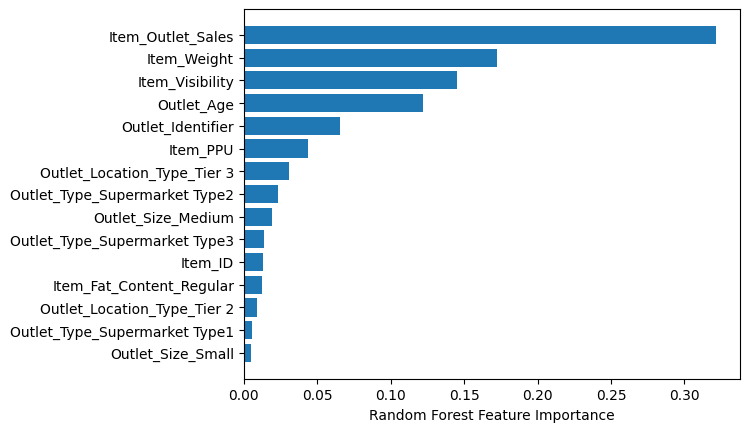

In [51]:
sorted_idx = mod_rf.feature_importances_.argsort() #type: ignore
plt.barh(combined_en.columns[sorted_idx], mod_rf.feature_importances_[sorted_idx]) #type: ignore
plt.xlabel("Random Forest Feature Importance")

In [53]:
new_en_data = combined_en.loc[:, ['Item_Outlet_Sales', 
                                  'Item_Weight', 
                                  'Item_Visibility', 
                                  'Outlet_Age', 
                                  'Outlet_Identifier', 
                                  'Item_PPU']]
new_en_data.head()

,Item_Outlet_Sales,Item_Weight,Item_Visibility,Outlet_Age,Outlet_Identifier,Item_PPU
0,3735.1380,9.30,0.016047,22,9,26.861204
1,443.4228,5.92,0.019278,12,3,8.153581
2,2097.2700,17.50,0.016760,22,9,8.092457
3,732.3800,19.20,0.000000,23,0,9.484115
4,994.7052,8.93,0.000000,34,1,6.031512


In [54]:
mod_rf_n, exp_var_rf_n = rand_search(model = RandomForestRegressor(), params = params_rf, df = new_en_data)
exp_var_rf_n

0.5723881927681916

##### New Data imporved Explained Variance by 0.03. Lets work on the Data to improve that further.

#### Light GBM

In [93]:
params_lgbm = {
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [30, 40, 50, 60, 70],    
    'n_jobs':[-1]
}

In [100]:
mod_lgbm, exp_var_lgbm = rand_search(model = LGBMRegressor(), params = params_lgbm, df = combined_en, subm='yes')
exp_var_lgbm

0.5847785601278728

#### XGBoosting Regressor

In [101]:
params_xg = {
    'n_estimators': [30, 40, 50, 60, 70, 100],
    'learning_rate': [0.1, 0.01, 0.05, 0.07, 0.015],
    'max_depth': [4, 5, 7, 8],
}

In [102]:
mod_xg, exp_var_xg = rand_search(model = XGBRegressor(), params = params_xg, df = combined_en)
exp_var_xg

0.5826720498517209

#### Bagging Regressor

In [103]:
params_bgr = {
    'base_estimator': [mod_xg, mod_lgbm, mod_lg, mod_rf],
    'n_estimators': [30, 40, 50, 60, 70, 100, 120],
    'bootstrap': [True, False],
    'oob_score': [True]
}

In [104]:
mod_bg, exp_var_bg = rand_search(model = BaggingRegressor(), params = params_bgr, df = combined_en, subm = 'yes')
exp_var_bg

0.5886335285627162